In [1]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv2D,Input,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.python.keras.layers.merge import concatenate
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing import image

In [2]:
from tensorflow.image import ssim
def ssim_fun(y_true,y_pred):
    s=ssim(y_true,y_pred,1)
    return s

def psnr(y_true,y_pred):
    return -10*K.log(
    K.mean(K.flatten((y_true-y_pred))**2)
    )/np.log(10)

model = tf.contrib.keras.models.load_model('./20190714/model_2000.h5',custom_objects={"psnr":psnr,"ssim_fun":ssim_fun})


In [61]:
 def cal_ssim(im1,im2):
    assert len(im1.shape) == 2 and len(im2.shape) == 2
    assert im1.shape == im2.shape
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
#     sigma1,sigma2,sigma12=1.5,1.5,1.5
    k1, k2, L = 0.01, 0.03, 1.0
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim


In [87]:
def ssim(im1,im2,max_val):
    k1=0.01
    k2=0.03
    c1=(k1*max_val)**2
    c2=(k2*max_val)**2
    
    mean0=im1.mean()
    mean1=im2.mean()
    num0 = mean0 * mean1 * 2.0
    den0 =mean0**2 + mean1**2
    luminance = (num0 + c1) / (den0 + c1)
    
    num1 = (im1*im2.mean()) * 2.0
    den1 = den0.mean()
    c2 *=1.0
    cs = (num1 - num0 + c2) / (den1 - den0 + c2)
    
    axes = np.full((2,2),[-3, -2])
#     ssim_val = (luminance * cs, axes).flatten()
    ssim_val=luminance * cs
    
    return ssim_val

s=ssim(pred[0,:,:],test_y[0,:,:],1.0)

In [90]:
print(s.mean())

0.003921212168300853


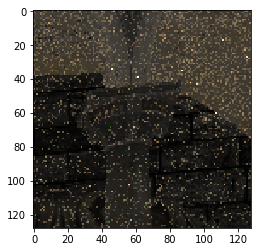

(1, 128, 128, 6)


In [40]:
path='./20190623/6_8.png'
imgs=cv2.imread(path)
imgs=imgs[:,:,::-1]
x=np.zeros((1,128,128,6))

x[0,0:128,0:128,:3]=imgs[0:128,0:128]/255
x[0,0:128,0:128,3:5]=imgs[0:128,256:384,:2]/255
x[0,0:128,0:128,5]=imgs[0:128,384:512,0]/255

images = np.vstack([x])
plt.imshow(images[0,:,:,:3])
plt.show()
print(images.shape)



In [41]:
path='./20190623/6_8.png'
imgs=cv2.imread(path)
imgs=imgs[:,:,::-1]

test_y=np.array((imgs[0:128,128:256]))
test_y=test_y[np.newaxis,:]
test_y=test_y/255

pred=model.predict(x)

loss_function,psnr_val,ssim_val=model.evaluate(x,test_y)
print("loss function:",loss_function)
print("PSNR: ",psnr_val)
print("SSIM: ",ssim_val)

1/1 [==============================] - 0s 5ms/step
loss function: 0.00022987675038166344
PSNR:  36.385047912597656
SSIM:  0.8969122767448425


In [65]:
print(pred.shape)
r=cal_ssim(pred[0,:,:,0],test_y[0,:,:,0])
g=cal_ssim(pred[0,:,:,1],test_y[0,:,:,1])
b=cal_ssim(pred[0,:,:,2],test_y[0,:,:,2])
print((r+g+b)/3)

(1, 128, 128, 3)
0.9810960624941821


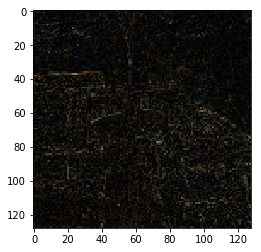

In [70]:
a=np.zeros((1,128,128,3))
for h in range(128):
    for w in range(128):
        r,g,b=pred[0,h,w]
#         *255
        r1,g1,b1=test_y[0,h,w]
        r=abs(r-r1)
        g=abs(g-g1)
        b=abs(b-b1)
        a[0,h,w]=r*5,g*5,b*5


plt.imshow(a[0])
plt.show()  
plt.imsave("./visualization/20190714/6_8_diffence", a[0])  

In [4]:
#     testing data path
# #     testing data path
path_t='./20190629/test5/1sppImage2.ppm'
path_n='./20190629/test5/1sppImage_Normal2.ppm'
path_d='./20190629/test5/1sppImage_Depth2.ppm'
x=np.zeros((1,720,1280,6))

#     get noise
img_x=cv2.imread(path_t)
img_x=img_x[:,:,::-1]
x[0,:,:,:3]=img_x

#     get normal
img_n=cv2.imread(path_n)
img_n=img_n[:,:,::-1]
x[0,:,:,3:5]=img_n[:,:,:2]

#     get depth
img_d=cv2.imread(path_d)
img_d=img_d[:,:,::-1]
x[0,:,:,5]=img_d[:,:,0]

In [4]:
# plt.matshow(x[0, :, :, 0], cmap='viridis')
y=np.zeros((1,128,128,3))
y[0,:,:,0]=x[0, :, :,5]
y[0,:,:,1]=x[0, :, :,5]
y[0,:,:,2]=x[0, :, :,5]

y=model.predict(x)
# plt.imsave('./visualization/predict',y[0])

In [4]:
from tensorflow.python.keras import models
layer_outputs = [layer.output for layer in model.layers[1:32]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

In [5]:
activations = activation_model.predict(x) 

In [6]:
layer_outputs

[<tf.Tensor 'conv1/Relu:0' shape=(?, ?, ?, 32) dtype=float32>,
 <tf.Tensor 'pool1/MaxPool:0' shape=(?, ?, ?, 32) dtype=float32>,
 <tf.Tensor 'conv2/Relu:0' shape=(?, ?, ?, 48) dtype=float32>,
 <tf.Tensor 'pool2/MaxPool:0' shape=(?, ?, ?, 48) dtype=float32>,
 <tf.Tensor 'conv3/Relu:0' shape=(?, ?, ?, 56) dtype=float32>,
 <tf.Tensor 'pool3/MaxPool:0' shape=(?, ?, ?, 56) dtype=float32>,
 <tf.Tensor 'up_sampling2d/ResizeNearestNeighbor:0' shape=(?, ?, ?, 56) dtype=float32>,
 <tf.Tensor 'unpool2/concat:0' shape=(?, ?, ?, 104) dtype=float32>,
 <tf.Tensor 'conv5/Relu:0' shape=(?, ?, ?, 56) dtype=float32>,
 <tf.Tensor 'up_sampling2d_1/ResizeNearestNeighbor:0' shape=(?, ?, ?, 56) dtype=float32>,
 <tf.Tensor 'unpool1/concat:0' shape=(?, ?, ?, 88) dtype=float32>,
 <tf.Tensor 'conv7/Relu:0' shape=(?, ?, ?, 48) dtype=float32>,
 <tf.Tensor 'up_sampling2d_2/ResizeNearestNeighbor:0' shape=(?, ?, ?, 48) dtype=float32>,
 <tf.Tensor 'inputs/concat:0' shape=(?, ?, ?, 54) dtype=float32>,
 <tf.Tensor 'conv8

(1, 128, 128, 32)


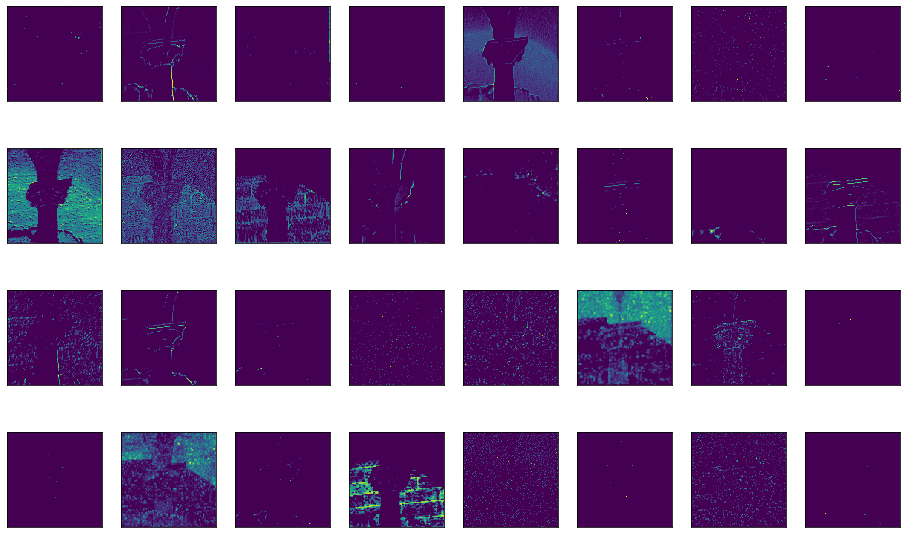

In [30]:
j=0
first_layer_activation = activations[j]
print(first_layer_activation.shape)

plt.figure(figsize=(8*2,10))
n=first_layer_activation.shape[3]/4
for i in range(first_layer_activation.shape[3]):
    ax = plt.subplot(4, n, i+1 )
    plt.imshow(first_layer_activation[0, :, :, i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis',fignum=1)
# plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis',fignum=2)

plt.savefig("./visualization/20190714/layer"+repr(j)+".png")
plt.show()

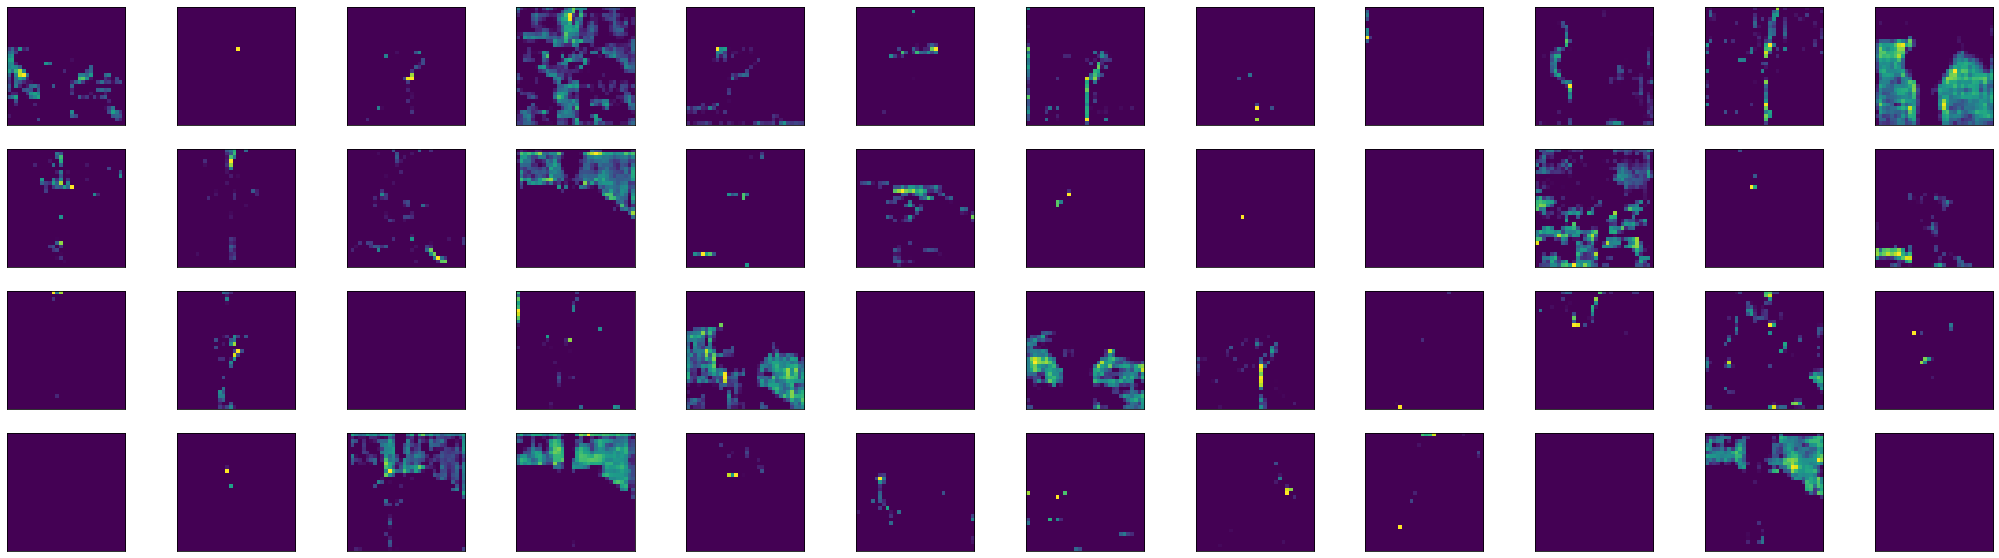

In [48]:
plt.figure(figsize=(6*6,10))
n=first_layer_activation.shape[3]/4
for i in range(first_layer_activation.shape[3]):
    ax = plt.subplot(4, n, i+1 )
    plt.imshow(first_layer_activation[0, :, :, i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis',fignum=1)
# plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis',fignum=2)

plt.savefig("./visualization/20190708/layer"+repr(i)+".png")
plt.show()

In [51]:
first_layer_activation = activations[17]
print(first_layer_activation.shape)

(1, 720, 1280, 32)


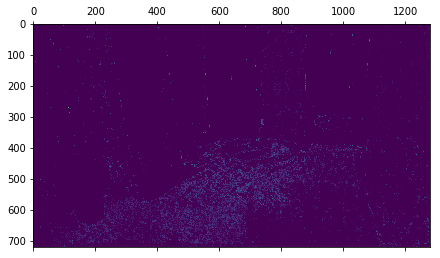

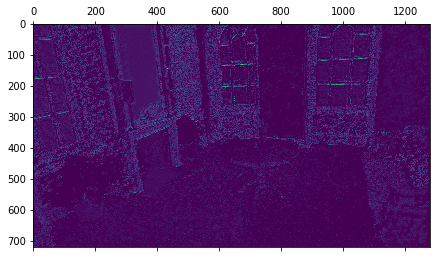

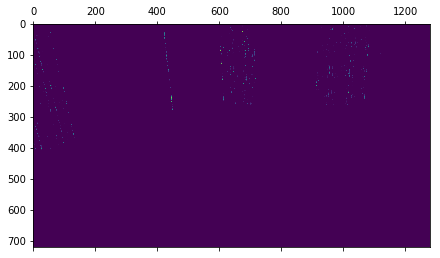

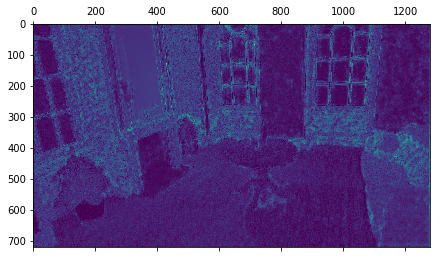

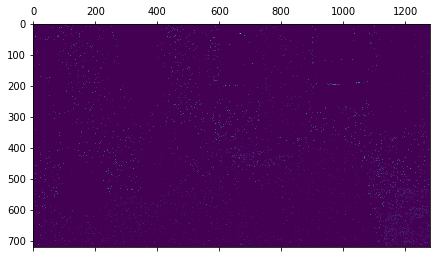

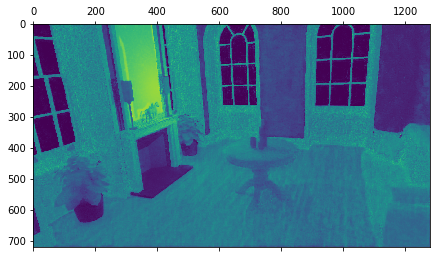

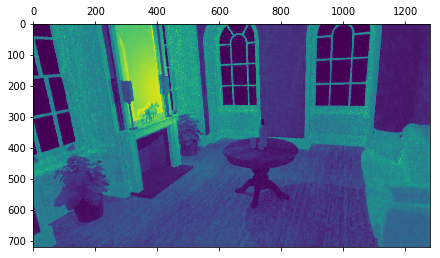

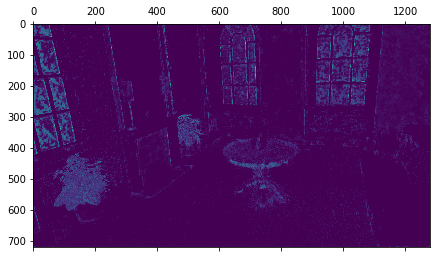

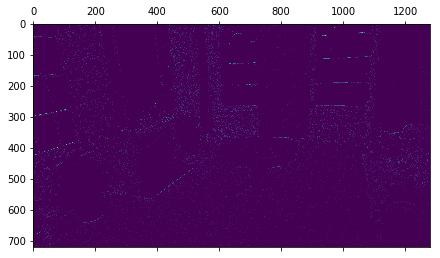

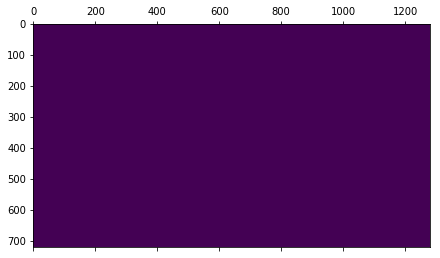

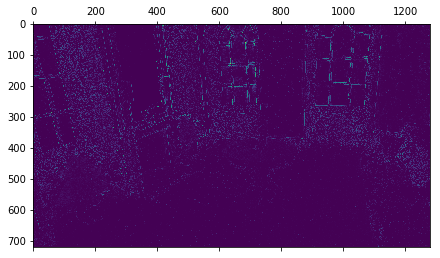

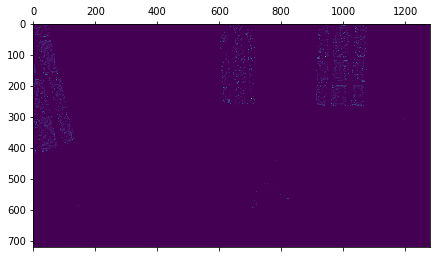

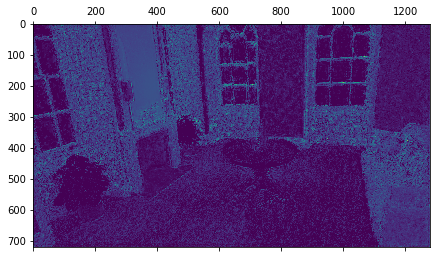

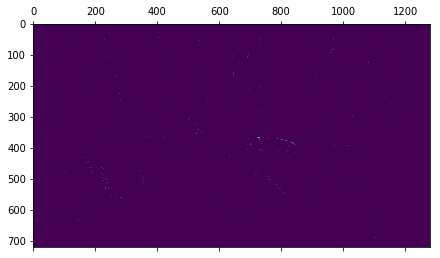

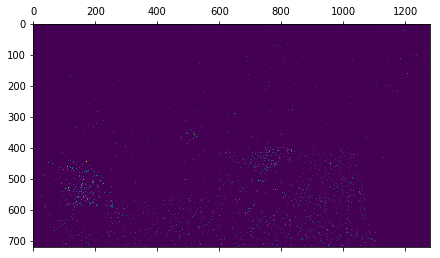

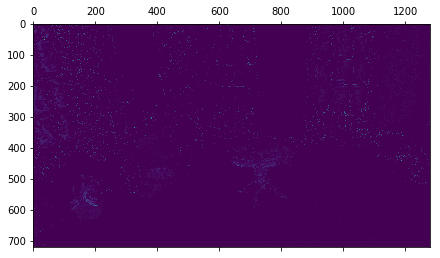

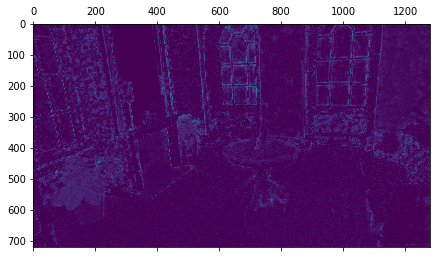

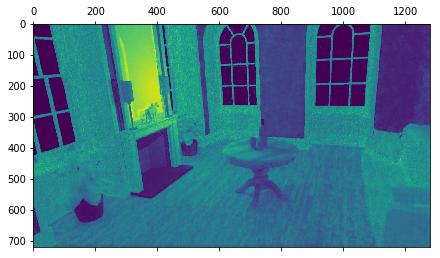

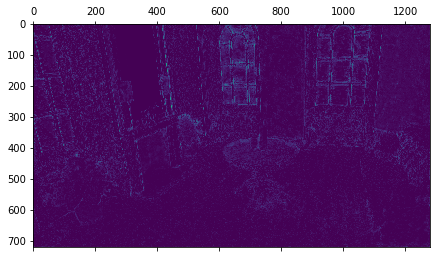

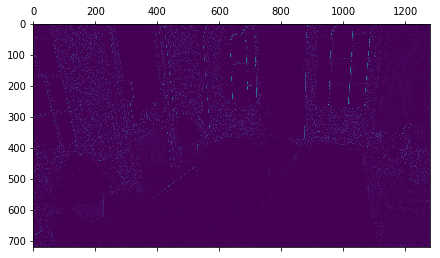

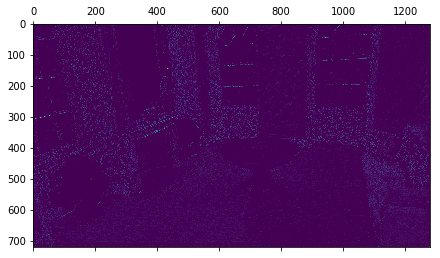

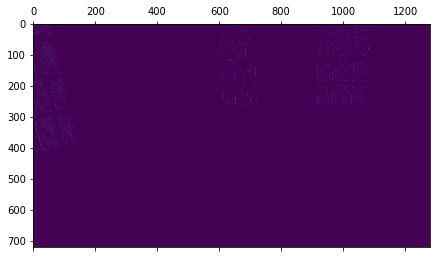

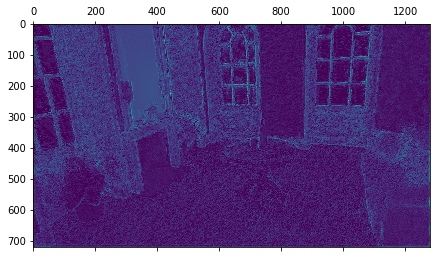

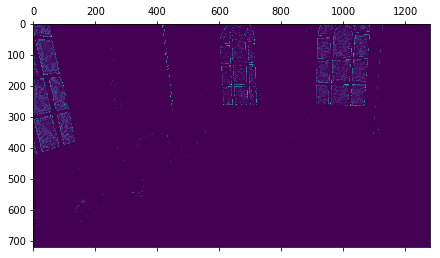

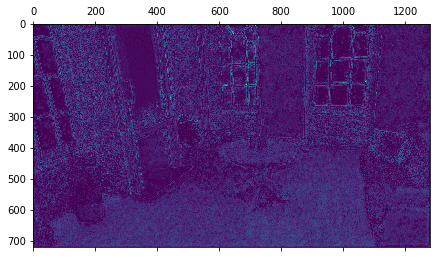

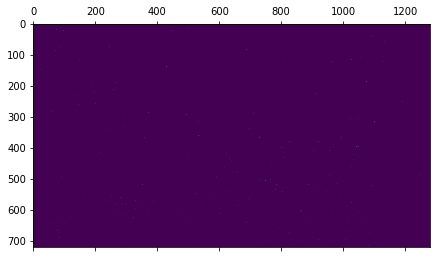

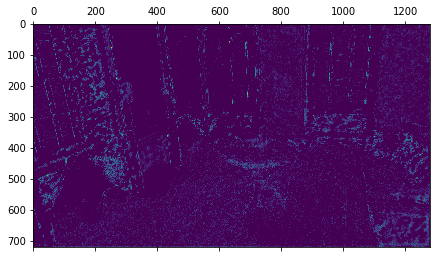

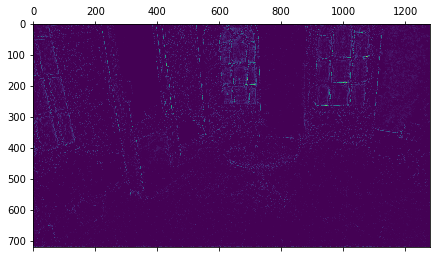

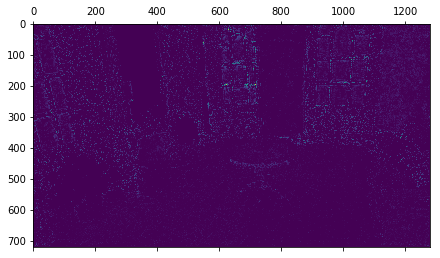

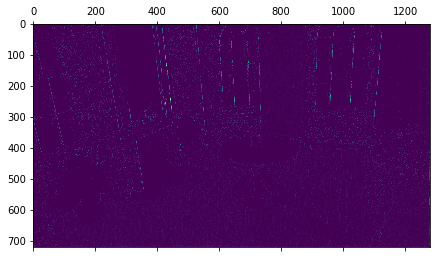

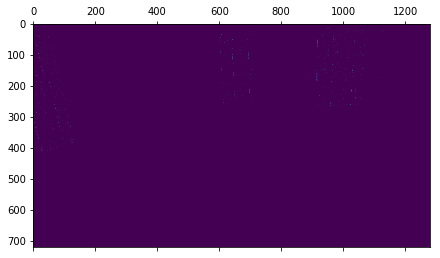

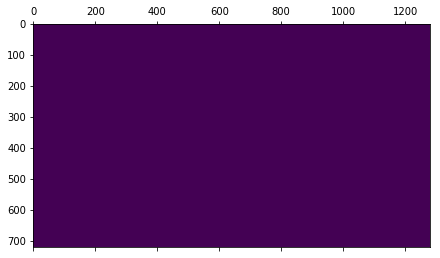

In [52]:
for i in range(first_layer_activation.shape[3]):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [33]:
-10*np.log(
np.mean(0.00070447
)
)/np.log(10)

31.521374966807716